### 【問題1】2次元畳み込み層の作成
### 【問題3】2次元畳み込み後の出力サイズ
### 【問題4】最大プーリング層の作成
### 【問題7】学習と推定

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import tensorflow as tf
# from keras.datasets import mnist


In [58]:
# Relu関数
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

# Sigmoid関数
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx

# Affine関数
class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 重み・バイアスパラメータの微分
        self.dW = None
        self.db = None

    def forward(self, x):
        # テンソル対応
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 入力データの形状に戻す（テンソル対応）
        return dx

# Softmax関数
def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True)   # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

# 交差エントロピー誤差
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

# Softmax関数とロス関数
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmaxの出力
        self.t = None # 教師データ

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 教師データがone-hot-vectorの場合
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

# 最適化
class SGD:

    """確率的勾配降下法（Stochastic Gradient Descent）"""

    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key] 

# 最適化
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)


In [59]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """
    関数の概要：入力データを計算しやすいように二次元へ変換する
               ※ブラックボックス扱いでよい
    ----------
    Parameters
        input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
        filter_h : フィルターの高さ
        filter_w : フィルターの幅
        stride : ストライド
        pad : パディング
    ----------
    Returns
        col : 2次元配列
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """
    Parameters
    ----------
    col :
    input_shape : 入力データの形状（例：(10, 1, 28, 28)）
    filter_h :
    filter_w
    stride
    pad
    Returns
    -------
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]


In [60]:
# 畳み込み層(Convolutionレイヤ)
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        """
        関数の概要 ： 畳み込み層用のコンストラクタ
        ----------
        Parameters
            W : 重み
            b : バイアス
            stride : ストライド
            pad : パディングする幅(1なら周囲に1つパディング)
        ----------
        Returns
            －
        """
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
    
    def forward(self, x):
        """
        関数の概要 ： 畳み込み層のフォワードプロパゲーション
        ----------
        Parameters
            x : 入力データ
        ----------
        Returns
            out : 出力データ
        """
        # 重み（フィルター）の各次元要素数をそれぞれの変数へ代入
        # 　FN : フィルター数（ハイパーパラメータ）
        # 　C  : チャンネル数（入力データ(x)と同じ値である必要がある）
        # 　FH : フィルターの縦幅
        # 　FW : フィルターの横幅
        FN, C, FH, FW = self.W.shape
        # 入力データの各次元要素数をそれぞれの変数へ代入
        # 　N : バッチ数
        # 　C : チャンネル数（重み(フィルター)(self.W)と同じ値である必要がある）
        # 　H : 入力データの縦幅
        # 　W : 入力データの横幅
        N, C, H, W = x.shape

        # 出力データのサイズを計算
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)
        # out_h = 1 + (H + 2*self.pad - FN) // self.stride
        # out_w = 1 + (W + 2*self.pad - FW) // self.stride

        # 出力データを計算しやすくするために、im2col関数を通してデータを2次元にする
        col = im2col(x, FH, FW, self.stride, self.pad)
        # im2colの出力結果と計算するために、重みを変形
        col_W = self.W.reshape(FN, -1).T

        # 出力データの計算
        out = col @ col_W + self.b
        # 出力データをreshapeした後、次元を戻す(N, H, W, C) ⇒ (N, C, H, W)
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        # backward用に値を保存
        self.x = x
        self.col = col
        self.col_W = col_W

        # 出力データを返す
        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx


In [61]:
# Poolingクラスの定義
class Pooling:
    def __init__(self, pool_h, pool_w, stride=2, pad=0):
        """
        関数の概要 ： プーリング層用のコンストラクタ
        ----------
        Parameters
            pool_h : プーリングするフィルタの高さ
            pool_w : プーリングするフィルタの幅
            stride : ストライド
            pad : パディングする幅(1なら周囲に1つパディング)
        ----------
        Returns
            －
        """
        # 初期化
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        # バックプロパゲーション用の変数
        self.x = None
        self.arg_max = None
    
    def forward(self, x):
        """
        関数の概要 ： プーリング層のフォワードプロパゲーション
        ----------
        Parameters
            x : 入力データ
        ----------
        Returns
            out : 出力データ
        """
        # 入力データの各次元要素数をそれぞれの変数へ代入
        # 　N : データ数
        # 　C : チャンネル数
        # 　H : 入力データの縦幅
        # 　W : 入力データの横幅
        N, C, H, W = x.shape

        # 出力データのサイズを計算
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        # im2col関数を使用して、2次元データへ変換
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        # 2次元にしたデータから最大値を取得
        out = np.max(col, axis=1)
        # 出力データの形へ戻す
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        # バックプロパゲーション用に入力データとプーリングした最大値のインデックスを保存しておく
        self.x = x
        self.arg_max = np.argmax(col, axis=1)

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx


In [62]:
# Scratch2dCNNClassifierクラスの定義
class Scratch2dCNNClassifier:
    """
    クラスの概要：次の構造をしている畳み込みニューラルネットワーク
    　conv - relu - pool - affine - relu - affine - softmax
    """
    def __init__(self,
                 input_dim=(1, 28, 28),
                 conv_param={"filter_num":30,
                             "filter_size":5,
                             "stride":1,
                             "pad":0},
                 hidden_size=100,
                 output_size=10,
                 weight_init_std=0.01):
        """
        関数の概要：SimpleConvNetのコンストラクタ
        ----------
        Parameters
            input_dim : 入力データの構造
            conv_param : フィルターの構造を持った辞書型変数
                filter_num : フィルターの数
                filter_size : チャンネル数
                stride : ストライド
                pad : パディング
            hidden_size : 隠れ層のニューロン数（ハイパーパラメータ）
            output_size : 最終出力結果となる要素数（ハイパーパラメータ）
            weight_init_std : 重みの標準偏差
                "relu"または"he"の場合は「heの初期値」を設定
                "sigmoid"または"xavier"の場合は「xavierの初期値」を設定
        ----------
        Returns
            －
        """
        # 初期値の設定
        filter_num = conv_param["filter_num"]
        filter_size = conv_param["filter_size"]
        filter_stride = conv_param["stride"]
        filter_pad = conv_param["pad"]
        input_size = input_dim[1]   # 入力データの行数

        # 折り畳み層の出力データのサイズ
        conv_output_size = (input_size - filter_size + 2*filter_pad) // filter_stride + 1
        # プール層の出力データのサイズ
        pool_output_size = int(filter_num * (conv_output_size / 2) * (conv_output_size / 2))

        # 重みとバイアスの初期化
        self.params = {}
        self.params["W1"] = weight_init_std * np.random.rand(filter_num, input_dim[0], filter_size, filter_size)
        self.params["b1"] = np.zeros(filter_num)
        self.params["W2"] = weight_init_std * np.random.rand(pool_output_size, hidden_size)
        self.params["b2"] = np.zeros(hidden_size)
        self.params["W3"] = weight_init_std * np.random.rand(hidden_size, output_size)
        self.params["b3"] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers["Conv1"] = Convolution(self.params["W1"],
                                           self.params["b1"],
                                           conv_param["stride"],
                                           conv_param["pad"])
        self.layers["Relu1"] = Relu()
        self.layers["Pool1"] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers["Affine1"] = Affine(self.params["W2"], self.params["b2"])
        self.layers["Relu2"] = Relu()
        self.layers["Affine2"] = Affine(self.params["W3"], self.params["b3"])
        # 推定や損失を求めるために他のレイヤと構造を分ける(他レイヤと同じ変数にしない)
        self.last_layer = SoftmaxWithLoss()

    # 推定
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    # 損失
    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    # 正確性
    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        acc = 0.0
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    # 勾配
    def gradient(self, x, t):
        """
        関数の概要：勾配を求める（誤差逆伝搬法）
        ----------
        Parameters
            x : 入力データ
            t : 教師ラベル
        ----------
        Returns
            各層の勾配を持ったディクショナリ変数
                grads['W1']、grads['W2']、...は各層の重み
                grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads


In [63]:
# Trainerクラスの定義
class Trainer:
    """
    クラスの概要：学習を行うクラス
    """
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20,
                 mini_batch_size=100,
                 optimizer='SGD',
                 optimizer_param={'lr':0.01}, 
                 evaluate_sample_num_per_epoch=None,
                 verbose=True):
        """
        関数の概要：Trainerのコンストラクタ
        ----------
        Parameters
            network : 学習に使用するNN(今回はSimpleConvNet)
            x_train : 訓練データ
            t_train : 訓練データの教師データ
            x_train : 検証データ
            t_train : 検証データの教師データ
            epochs : 学習回数
            mini_batch_size : バッチサイズ
            optimizer : 最適化手法
            optimizer_param : 最適化手法で使用するパラメータ
                lr : 学習率
            evaluate_sample_num_per_epoch : 1学習で使用するサンプル数
            verbose : データの表示有無
        ----------
        Returns
            －
        """
        # 初期化
        self.network = network
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch
        self.verbose = verbose

        # optimizerの設定
        # optimizer_class_dict = {'sgd':SGD, 'momentum':Momentum, 'nesterov':Nesterov,
        #                         'adagrad':AdaGrad, 'rmsprop':RMSprop, 'adam':Adam}
        optimizer_class_dict = {"sgd":SGD, "adam":Adam}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)

        self.train_size = x_train.shape[0]                              # 訓練データの行数
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1) # 1学習時のループ回数
        self.max_iter = int(epochs * self.iter_per_epoch)               # 学習回数
        self.current_iter = 0       # 1学習内の現在のループ数
        self.current_epoch = 0      # 現在の学習回数
        self.train_loss_list = []   # 訓練データ学習時のロス関数の返り値
        self.train_acc_list = []    # 訓練データの正確性
        self.test_acc_list = []     # 検証データの正確性

    def train_step(self):
        """
        関数の概要：学習
        ----------
        Parameters
            －
        ----------
        Returns
            －
        """
        # 初期化
        batch_mask = np.random.choice(self.train_size, self.batch_size) # ミニバッチのサイズを設定
        x_batch = self.x_train[batch_mask]  # 訓練データのミニバッチ
        t_batch = self.t_train[batch_mask]  # 検証データのミニバッチ
        # 初期化時点での勾配を求める
        grads = self.network.gradient(x_batch, t_batch)
        # 勾配を基に最適化
        self.optimizer.update(self.network.params, grads)
        # 最適化した状態での損失を求める
        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)   # 配列に損失を格納
        # verbose==Trueであれば表示
        if self.verbose: print("train loss:" + str(loss))
        # 1学習でのループ
        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1 # ループ回数をカウント +1
            x_train_sample, t_train_sample = self.x_train, self.t_train # 代入
            x_test_sample, t_test_sample = self.x_test, self.t_test     # 代入
            # 1学習で使用するサンプル数（ハイパーパラメータ）
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                # evaluate_sample_num_per_epochの値に合わせてデータサイズを調整
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]
            # 訓練データの正確性
            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            # 検証データの正確性
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)
            # verbose==Trueであれば表示
            if self.verbose: print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")
        self.current_iter += 1

    def train(self):
        # 学習回数分ループ
        for i in range(self.max_iter):
            # 1回学習
            self.train_step()
        # (今回は)SimpleConvNetのaccracyクラスで正確性を測る
        test_acc = self.network.accuracy(self.x_test, self.t_test)
        # verbose==Trueなら検証データの正確性を表示
        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc))


In [64]:
# MNISTデータの読み込み
(x_train, t_train), (x_test, t_test) = tf.keras.datasets.mnist.load_data()

# 処理に時間がかかるかもしれないので、データ数を削減(10分の1) 
x_train, t_train = x_train[:6000], t_train[:6000]
x_test, t_test = x_test[:1000], t_test[:1000]

# データ数、チャンネル数、縦、横、に変形
x_train = x_train[:,np.newaxis,:,:]
x_test = x_test[:,np.newaxis,:,:]


In [65]:
# ハイパーパラメータの設定
epochs = 2
# epochs = 10

# 学習に使用するScratch2dCNNClassifierのインスタンス化
network = Scratch2dCNNClassifier(input_dim=(1,28,28), 
                        conv_param = {"filter_num": 30,
                                      "filter_size": 5,
                                      "stride": 1,
                                      "pad": 0},
                        hidden_size=100,
                        output_size=10,
                        weight_init_std=0.01)

# 学習を行うTrinerのインスタンス化
trainer = Trainer(network,                              # ニューラルネットワーク
                  x_train,                              # 訓練データ
                  t_train,                              # 訓練データの教師データ
                  x_test,                               # 検証データ
                  t_test,                               # 検証データの教師データ
                  epochs=epochs,                        # 学習回数
                  mini_batch_size=100,                  # ミニバッチサイズ
                  optimizer='Adam',                     # 最適化手法
                  optimizer_param={'lr': 0.001},        # 学習率
                  evaluate_sample_num_per_epoch=1000)   # 1学習で使用するサンプル数

# 学習
trainer.train()


train loss:5.765162547205821
=== epoch:1, train acc:0.1, test acc:0.094 ===
train loss:6.62129061778066
train loss:6.518560465134152
train loss:5.34377341436276
train loss:3.374696259568249
train loss:2.4172800602351567
train loss:2.304260224726391
train loss:2.2991431731892353
train loss:2.303502081026874
train loss:2.3023410384770537
train loss:2.3028397667653913
train loss:2.3025401055377643
train loss:2.30267862111266
train loss:2.3025741008145744
train loss:2.302462336761758
train loss:2.302182311236274
train loss:2.3022833951767607
train loss:2.3025640232008255
train loss:2.302603211831326
train loss:2.3022558983227746
train loss:2.3019311674642413
train loss:2.3020226025504704
train loss:2.3026191776476304
train loss:2.302840572376619
train loss:2.302576873458815
train loss:2.303089242908891
train loss:2.302435017240725
train loss:2.3024038131070736
train loss:2.3018672911271394
train loss:2.3023443449193053
train loss:2.3023747517210955
train loss:2.3024277978886527
train loss:

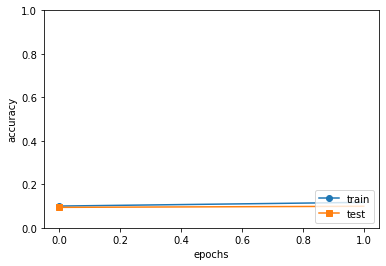

In [66]:
# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()
